In [337]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from random import *

### Funciones útiles

In [338]:
# Función para inicializar el grid con celdas infectadas aleatoriamente
def initialize_grid(M, N, I0):
    grid = np.zeros((M, N), dtype=int)  # Todas las celdas son susceptibles inicialmente (0)
    
    # Elegir I0 celdas aleatorias para ser infectadas
    infected_cells = sample([(i, j) for i in range(M) for j in range(N)], I0)
    for cell in infected_cells:
        grid[cell] = 1  # Infectadas (estado 1)
    
    return grid

In [339]:
# Función para obtener la vecindad de una celda (i, j) con radio rad
def get_neighborhood(grid, i, j, rad):
    M, N = grid.shape
    neighborhood = grid[max(0, i-rad):min(M, i+rad+1), max(0, j-rad):min(N, j+rad+1)]
    return neighborhood

In [340]:
# Función para ejecutar la simulación
def simulate_sir(M, N, T, I0, rad, beta, gamma):
    grid = initialize_grid(M, N, I0)
    grid_history = []  # Historial del grid
    population_counts = []  # Historial de S, I, R
    
    for _ in range(T):
        new_grid = grid.copy()
        S_count = 0
        I_count = 0
        R_count = 0
        
        for i in range(M):
            for j in range(N):
                if grid[i, j] == 0:  # Susceptible
                    neighborhood = get_neighborhood(grid, i, j, rad)
                    infected_neighbors = np.sum(neighborhood == 1)
                    total_neighbors = neighborhood.size
                    
                    # Probabilidad de infección
                    if infected_neighbors > 0:
                        infection_probability = beta * (infected_neighbors)
                        if random() < infection_probability:
                            new_grid[i, j] = 1  # Infectar la celda
                
                elif grid[i, j] == 1:  # Infectado
                    # Probabilidad de recuperación
                    if random() < gamma:
                        new_grid[i, j] = 2  # Recuperar la celda
        
        # Actualizar el grid y registrar las cantidades de S, I, R
        grid = new_grid
        S_count = np.sum(grid == 0)
        I_count = np.sum(grid == 1)
        R_count = np.sum(grid == 2)
        
        grid_history.append(grid.copy())
        population_counts.append((S_count, I_count, R_count))
    
    return grid_history, population_counts

In [341]:
# Función para graficar el promedio de S, I, R
def plot_SIR(S_avg, I_avg, R_avg, T, beta, gamma):
    t = np.linspace(0, T, len(S_avg))
    plt.figure(figsize=(10, 6))
    plt.plot(t, S_avg, label="S(t) - Susceptibles", color='red')
    plt.plot(t, I_avg, label="I(t) - Infectados", color='green')
    plt.plot(t, R_avg, label="R(t) - Recuperados", color='blue')
    plt.title(f"Resultados para β={beta}, γ={gamma}")
    plt.xlabel("Tiempo")
    plt.ylabel("Población")
    plt.legend()
    plt.grid(True)
    plt.show()

In [342]:
# Implementación Runge-Kutta 4
def runge_kutta_4(f, y0, t0, tf, h, beta, gamma, N):
  t = np.arange(t0, tf + h, h)
  y = np.zeros((len(t), len(y0)))
  y[0] = y0
  
  for i in range(1, len(t)):
      ti = t[i - 1]
      yi = y[i - 1]
      
      k1 = np.array(f(ti, yi, beta, gamma, N))
      k2 = np.array(f(ti + h/2, yi + h * k1 / 2, beta, gamma, N))
      k3 = np.array(f(ti + h/2, yi + h * k2 / 2, beta, gamma, N))
      k4 = np.array(f(ti + h, yi + h * k3, beta, gamma, N))
      
      y[i] = yi + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
  
  return t, y

In [343]:
# Sistema EDO
def theoretical_sir(t, y, beta, gamma, N):
  S, I, R = y
  dS_dt = -beta * S * I / N
  dI_dt = beta * S * I / N - gamma * I
  dR_dt = gamma * I
  return np.array([dS_dt, dI_dt, dR_dt])

### Inicializar variables utilizadas en ambos métodos

In [344]:
# Parámetros del modelo
M = N = 20  # Tamaño del grid cuadrado
T = 200  # Tiempo de simulación
I0 = 2  # Número inicial de infectados
rad = 1  # Radio de interacción
beta = 0.4  # Probabilidad de infección
gamma = 0.1  # Probabilidad de recuperación

### Modelo con autómata celular

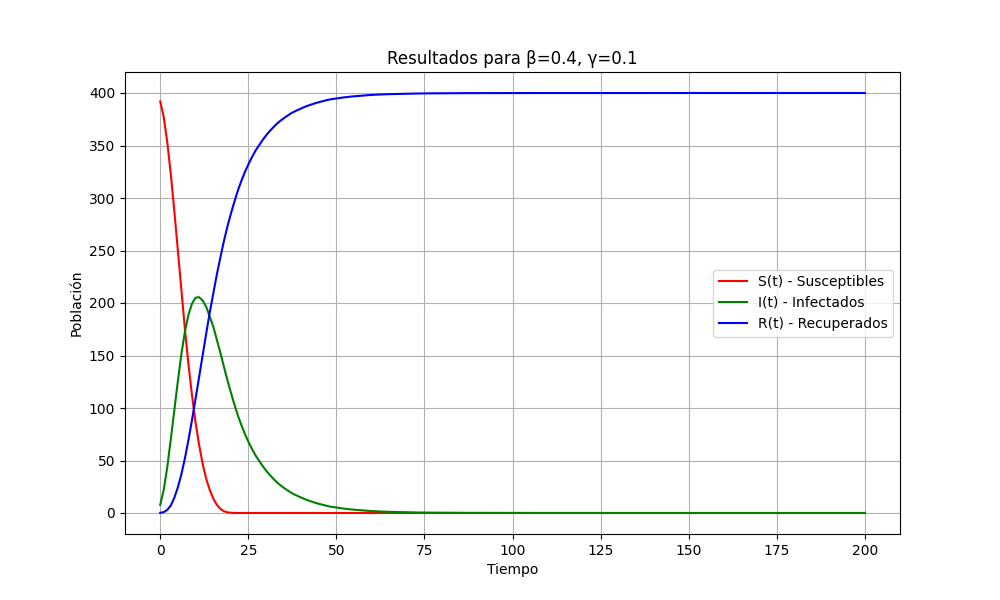

In [345]:
N_exp = 200  # Número de repeticiones de la simulación

total_S = np.zeros((T,))
total_I = np.zeros((T,))
total_R = np.zeros((T,))

for i in range(N_exp):
    grid_history, population_counts = simulate_sir(M, N, T, I0, rad, beta, gamma)
    total_S += np.array([x[0] for x in population_counts])
    total_I += np.array([x[1] for x in population_counts])
    total_R += np.array([x[2] for x in population_counts])

avg_S = total_S / N_exp
avg_I = total_I / N_exp
avg_R = total_R / N_exp

plot_SIR(avg_S, avg_I, avg_R, T, beta, gamma)

### Solución teórica

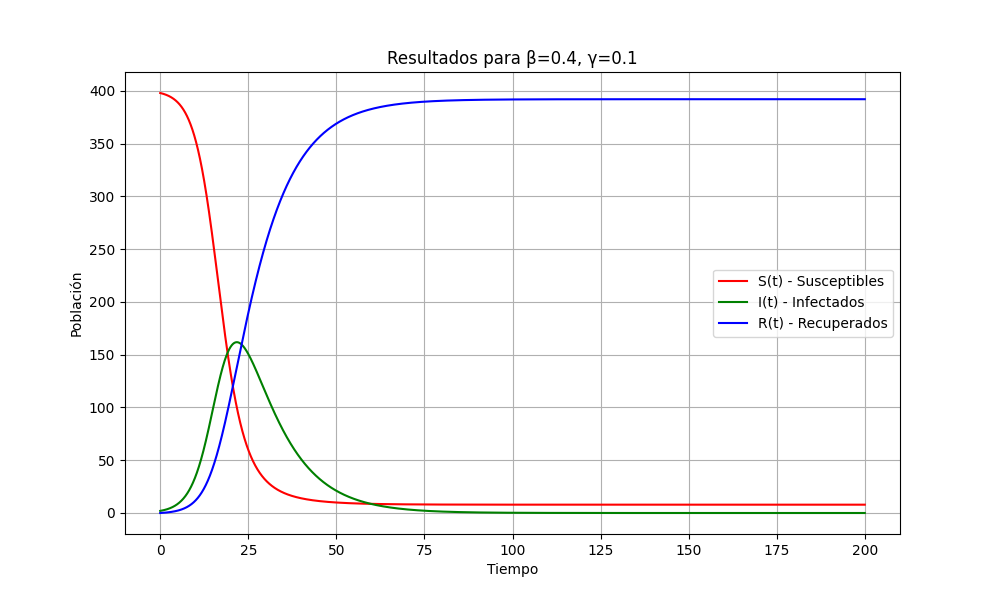

In [346]:
# Parámetros iniciales
S = M * N - I0  # Número inicial de susceptibles
R = 0  # Número inicial de recuperados
h = 0.01  # Tamaño de paso
t0 = 0  # Tiempo inicial
tf = T  # Tiempo final

y0 = np.array([S, I0, R])

t_sol, y_sol = runge_kutta_4(theoretical_sir, y0, t0, tf, h, beta, gamma, N*M)
fS, fI, fR = y_sol[:, 0], y_sol[:, 1], y_sol[:, 2]

plot_SIR(fS, fI, fR, T, beta, gamma)